In [ ]:
!pip install yfinance --quiet


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize


In [21]:
# Introduce los símbolos bursátiles separados por comas (por ejemplo: AAPL, MSFT, GOOGL)
tickers_entrada = input("Introduce los símbolos bursátiles separados por comas: ")
tickers = [ticker.strip().upper() for ticker in tickers_entrada.split(',')]


Introduce los símbolos bursátiles separados por comas: AAPL, ^GSPC, META, GC=F


In [22]:
# Descargar datos históricos
df = yf.download(tickers, start="2024-01-01", end="2025-06-01")['Close']
retorno = df.pct_change().dropna()
media_de_retornos = retorno.mean()
matriz_covarianza = retorno.cov()
cantidad = len(tickers)


[*********************100%***********************]  4 of 4 completed
<ipython-input-22-2328078753>:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retorno = df.pct_change().dropna()


In [23]:
def portfolio_performance(pesos, media_de_retornos, matriz_covarianza):
    retorno = np.dot(pesos, media_de_retornos)
    std = np.sqrt(np.dot(pesos.T, np.dot(matriz_covarianza, pesos)))
    return retorno, std

def negative_sharpe_ratio(pesos, media_de_retornos, matriz_covarianza, tasa_libre_riesgo):
    p_return, p_std = portfolio_performance(pesos, media_de_retornos, matriz_covarianza)
    return -(p_return - tasa_libre_riesgo) / p_std


In [25]:
tasa_libre_riesgo = 0.02 / 252  # tasa libre de riesgo diaria
init_guess = cantidad * [1. / cantidad]
bounds = tuple((0, 1) for _ in range(cantidad))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

sharpe_result = minimize(negative_sharpe_ratio, init_guess, args=(media_de_retornos, matriz_covarianza, tasa_libre_riesgo),
                         method='SLSQP', bounds=bounds, constraints=constraints)

opt_pesos = sharpe_result.x
opt_retorno, opt_riesgo = portfolio_performance(opt_pesos, media_de_retornos, matriz_covarianza)
sharpe_ratio = (opt_retorno - tasa_libre_riesgo) / opt_riesgo
retorno_anual = opt_retorno * 252
riesgo_anual = opt_riesgo * np.sqrt(252)
riesgolibre_anual = tasa_libre_riesgo * 252
sharpe_ratio_anual = (retorno_anual - riesgolibre_anual) / riesgo_anual

# Mostrar resultados anuales
print("Ponderaciones óptimas:")
for ticker, pesos in zip(tickers, opt_pesos):
    print(f"{ticker}: {pesos:.2%}")
print(f"Rendimiento esperado anual: {retorno_anual:.2%}")
print(f"Riesgo (volatilidad) anual: {riesgo_anual:.2%}")
print(f"Ratio de Sharpe anual: {sharpe_ratio_anual:.2f}")

Ponderaciones óptimas:
AAPL: 0.00%
^GSPC: 77.15%
META: 22.85%
GC=F: 0.00%
Rendimiento esperado anual: 38.72%
Riesgo (volatilidad) anual: 15.94%
Ratio de Sharpe anual: 2.30


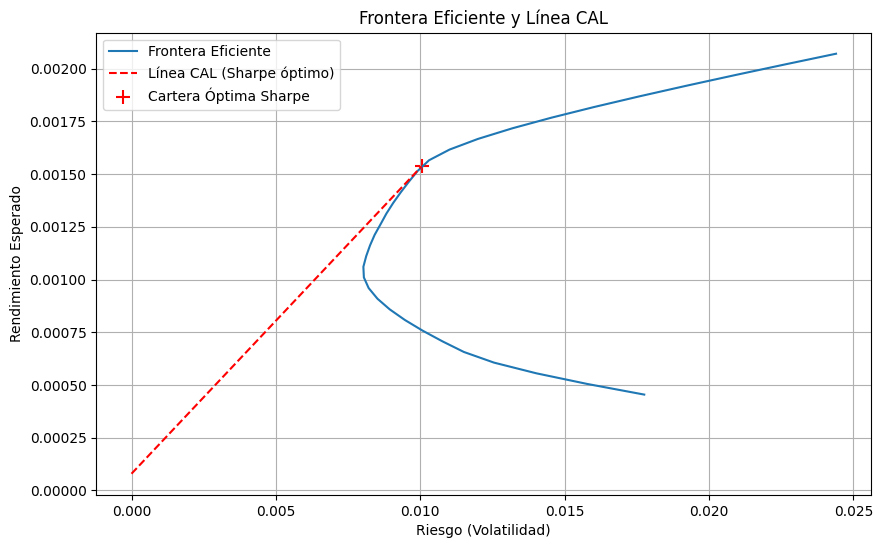

In [27]:
target_returns = np.linspace(0.0, 0.005, 100)
efficient_portfolios = []

for r in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.dot(x, media_de_retornos) - r})
    result = minimize(lambda w: portfolio_performance(w, media_de_retornos, matriz_covarianza)[1],
                      init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        efficient_portfolios.append(result)

eff_retorno = [portfolio_performance(p.x, media_de_retornos, matriz_covarianza)[0] for p in efficient_portfolios]
eff_riesgo = [portfolio_performance(p.x, media_de_retornos, matriz_covarianza)[1] for p in efficient_portfolios]

# Línea CAL
cal_x = [0, opt_riesgo]
cal_y = [tasa_libre_riesgo, opt_retorno]

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(eff_riesgo, eff_retorno, label='Frontera Eficiente')
plt.plot(cal_x, cal_y, 'r--', label='Línea CAL (Sharpe óptimo)')
plt.scatter(opt_riesgo, opt_retorno, c='red', marker='+', s=100, label='Cartera Óptima Sharpe')
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera Eficiente y Línea CAL')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Simular evolución del valor de la cartera a lo largo del tiempo
rendimientos_cartera = retorno.dot(opt_pesos)
valor_cartera = (1 + rendimientos_cartera).cumprod()

# Calcular drawdown
pico_acumulado = valor_cartera.cummax()
drawdown = (valor_cartera - pico_acumulado) / pico_acumulado
max_drawdown = drawdown.min()

print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(valor_cartera, label='Valor de la Cartera')
plt.plot(pico_acumulado, linestyle='--', label='Pico Acumulado')
plt.fill_between(drawdown.index, valor_cartera, pico_acumulado, color='red', alpha=0.3, label='Drawdown')
plt.title('Evolución del Valor de la Cartera y Drawdown')
plt.legend()
plt.grid(True)
plt.show()
